# Data Preprocessing

In [113]:
import matplotlib.pylab as pl
import shap
import xgboost
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from functools import reduce
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# print the JS visualization code to the notebook
shap.initjs()

In [2]:
df = pd.read_csv('/Users/jemma/Desktop/LifeBook/table_nephritis_age.csv')

In [3]:
df = df[df.columns[1:].to_list()]
df = df.drop(['Race: Other Race - Including Multi-Racial'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1756 entries, 0 to 1755
Data columns (total 17 columns):
Gender                                   1756 non-null int64
Age                                      1756 non-null int64
Race: Non-Hispanic White                 1756 non-null int64
Race: Non-Hispanic Black                 1756 non-null int64
Race: Mexican American                   1756 non-null int64
Race: Other Hispanic                     1756 non-null int64
Race: Non-Hispanic Asian                 1756 non-null int64
Diabetes                                 1756 non-null int64
High blood pressure (1 time)             1756 non-null int64
High blood pressure (2 or more times)    1756 non-null int64
Coronary heart disease                   1756 non-null int64
Congestive heart failure                 1756 non-null int64
Heart attack                             1756 non-null int64
# of times urinate in night              1756 non-null int64
Albumin                                

In [4]:
X = df[df.columns[0:-1]].values
y = df['Nephritis'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [5]:
print(X.shape)
print(y.shape)

(1756, 16)
(1756,)


# Modeling Process

## Model 1: Logistic Regression Classifier Model

In [6]:
class LogisticRegressionClassifier:

    def __init__(self, n=100):
        self.n = n

    def fit(self, X, y, random_state=42, criterion='entropy'):
        X_train_p = X[y==1]
        X_train_n = X[y==0]
        y_train_p = y[y==1]
        y_train_n = y[y==0]
        l = sum(y_train_p)
        clf_list = []
        np.random.seed(seed=random_state)
        for i in range(self.n):
            idx_n = np.random.choice(range(X_train_n.shape[0]), l)
            idx_p = np.random.choice(range(X_train_p.shape[0]), l)
            X_train_f = np.concatenate([X_train_n[idx_n, :], X_train_p[idx_p]])
            y_train_f = np.concatenate([y_train_n[idx_n], y_train_p[idx_p]])
            clf = LogisticRegression()
            clf.fit(X_train_f, y_train_f)
            clf_list.append(clf)
            print(f'\rClassifier {i+1} completed.', end='')
        self.clfs = clf_list        
    
    def coefficients(self):
        feature_importance = abs(self.clfs[0].coef_)
        for tree in self.clfs[1:]:
            feature_importance += tree.coef_
        return feature_importance/ self.n
    
    def predict(self, X):
        result_list = list(map(lambda clf: clf.predict_proba(X)[:,1], self.clfs)) # proba of label: y==1
        score = reduce(lambda a, b: a+b, result_list) / len(self.clfs)
        return score
        
    def report(self, X, y):
        y_hat = self.predict(X)
        print(classification_report(y_test, 1.*(y_hat>0.5)))
    
    def predict_proba(self,X):
        result_list = list(map(lambda clf: 100*clf.predict_proba(X)[:,1], self.clfs))
        proba = reduce(lambda a, b: a+b, result_list) / len(self.clfs)
        return proba

### Model Training

In [7]:
btc = LogisticRegressionClassifier(500)
btc.fit(X_train, y_train)
y_hat = 1.0 * (btc.predict(X_test)>0.5)

Classifier 500 completed.

In [8]:
btc.coefficients() # avg coefficients of n classifiers 

array([[ 0.0880045 ,  0.0198977 , -0.29665388, -0.18808122,  0.01389015,
        -0.4804267 , -0.36880884,  0.73312658, -0.85436199,  0.01770376,
        -0.07602699,  0.60173747,  0.432666  ,  0.17576491, -0.06250145,
         0.23947125]])

### Risk Score of test data

In [9]:
reshaped_X_test = pd.DataFrame(X_test)
reshaped_X_test.index = np.arange(1,len(reshaped_X_test)+1)

In [10]:
predictors_name = pd.DataFrame(df[df.columns[0:-1]].columns)
predictors_name.loc[predictors_name.index.max() + 1] = "Risk Score"
predictors_name_transpose = predictors_name.transpose()

In [35]:
reshaped_risk_score = pd.DataFrame(btc.predict_proba(X_test).reshape(-1,1))
reshaped_risk_score.index = np.arange(1,len(reshaped_risk_score)+1)
risk_score_tb = pd.concat([reshaped_X_test,reshaped_risk_score], axis=1, ignore_index=True)
risk_score_tb_final = risk_score_tb.rename(columns= predictors_name_transpose.loc[0])
#risk_score_tb_final.to_excel('risk_score_tb_final.xls')

In [12]:
risk_score_tb_final.head()

,Gender,Age,Race: Non-Hispanic White,Race: Non-Hispanic Black,Race: Mexican American,Race: Other Hispanic,Race: Non-Hispanic Asian,Diabetes,High blood pressure (1 time),High blood pressure (2 or more times),Coronary heart disease,Congestive heart failure,Heart attack,# of times urinate in night,Albumin,Creatinine,Risk Score
1,0,80,0,1,0,0,0,0,1,1,0,0,0,2,0,0,51.393288
2,0,69,0,0,1,0,0,0,1,1,0,0,0,1,0,0,46.703444
3,0,54,0,1,0,0,0,0,1,1,0,0,0,1,0,0,34.752578
4,1,80,0,1,0,0,0,0,1,1,0,1,0,2,0,0,67.324197
5,0,45,0,1,0,0,0,0,1,1,0,0,0,3,0,0,38.736283


In [13]:
reshaped_cof = pd.DataFrame(btc.coefficients().reshape(-1,1))
predictors_final = pd.DataFrame(df[df.columns[0:-1]].columns)
predictors_final.index = np.arange(1,len(predictors_final)+1)
reshaped_cof.index =  np.arange(1,len(reshaped_cof)+1)

In [14]:
coefficient_tb1= pd.concat([predictors_final,reshaped_cof], axis=1, ignore_index=True)
coefficient_tb2 = coefficient_tb1.rename(columns={0: "Predictor", 1: "Coefficient"})
coefficient_tb_final = coefficient_tb2.sort_values(by=["Coefficient"],ascending=False)
coefficient_tb_final.head(10)
#coefficient_tb_final.to_csv('coefficient_tb_final.csv')

,Predictor,Coefficient
8,Diabetes,0.733127
12,Congestive heart failure,0.601737
13,Heart attack,0.432666
16,Creatinine,0.239471
14,# of times urinate in night,0.175765
1,Gender,0.088004
2,Age,0.019898
10,High blood pressure (2 or more times),0.017704
5,Race: Mexican American,0.013890
15,Albumin,-0.062501


### Model Prediction Accuracy

In [15]:
print(classification_report(y_true=y_test, y_pred=y_hat))

              precision    recall  f1-score   support

           0       0.86      0.71      0.78       343
           1       0.37      0.59      0.45        96

    accuracy                           0.69       439
   macro avg       0.62      0.65      0.62       439
weighted avg       0.75      0.69      0.71       439



In [16]:
btc = LogisticRegressionClassifier(500)
btc.fit(X_train, y_train)
y_hat_train = 1.0 * (btc.predict(X_train)>0.5)

Classifier 500 completed.

In [17]:
print(classification_report(y_true=y_train, y_pred=y_hat_train))

              precision    recall  f1-score   support

           0       0.86      0.65      0.74      1043
           1       0.32      0.61      0.42       274

    accuracy                           0.64      1317
   macro avg       0.59      0.63      0.58      1317
weighted avg       0.75      0.64      0.67      1317



In [18]:
confusion_matrix(y_true=y_test, y_pred=y_hat)

array([[245,  98],
       [ 39,  57]])

### Feature Importance

In [19]:
feature_importance = abs(coefficient_tb_final[coefficient_tb_final.columns[1]])
feature_importance = 100.0 * (feature_importance / feature_importance.max())

In [20]:
score = feature_importance.head(10)
predictors_10 = coefficient_tb_final[coefficient_tb_final.columns[0]].head(10)
feature_importance_table = pd.concat([predictors_10,score], axis=1)
feature_importance_table
feature_importance_table_desc = feature_importance_table.sort_values(by=["Coefficient"],ascending=True)
feature_importance_table_desc

,Predictor,Coefficient
5,Race: Mexican American,1.625792
10,High blood pressure (2 or more times),2.072162
2,Age,2.328954
15,Albumin,7.315570
1,Gender,10.300610
14,# of times urinate in night,20.572651
16,Creatinine,28.029249
13,Heart attack,50.642000
12,Congestive heart failure,70.431209
8,Diabetes,85.809831


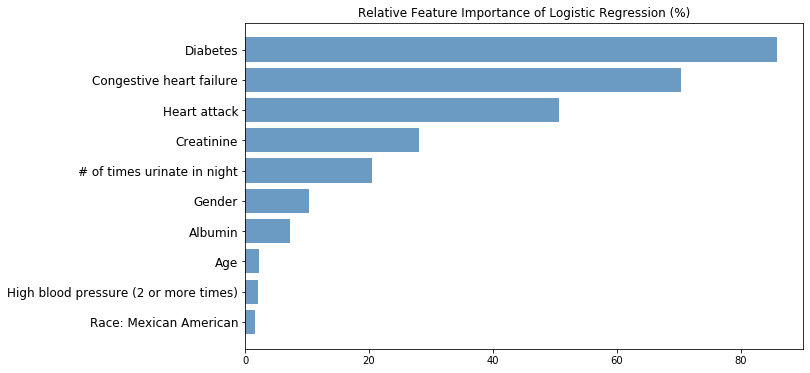

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,6))

share = feature_importance_table_desc[feature_importance_table_desc.columns[1]]
plt.barh(range(10), share, align = 'center',color='steelblue', alpha = 0.8)

plt.yticks(range(10),feature_importance_table_desc[feature_importance_table_desc.columns[0]], fontsize=12)
#ax.set_xlabels('Relative Feature Importance (%)')
#xticks(np.arange(10), ['Tom', 'Dick', 'Sue',]) 
#plt.tight_layout()   
plt.title('Relative Feature Importance of Logistic Regression (%)')
plt.show()

In [76]:
feature_names = ["Gender", "Age", "Race: Non-Hispanic White", "Race: Non-Hispanic Black", "Race: Mexican American", "Race: Other Hispanic", "Race: Non-Hispanic Asian", "Diabetes", "High blood pressure (1 time)", "High blood pressure (2 or more times)", "Coronary heart disease", "Congestive heart failure","Heart attack","# of times urinate in night", "Albumin","Creatinine"]

In [77]:
feature_names

['Gender',
 'Age',
 'Race: Non-Hispanic White',
 'Race: Non-Hispanic Black',
 'Race: Mexican American',
 'Race: Other Hispanic',
 'Race: Non-Hispanic Asian',
 'Diabetes',
 'High blood pressure (1 time)',
 'High blood pressure (2 or more times)',
 'Coronary heart disease',
 'Congestive heart failure',
 'Heart attack',
 '# of times urinate in night',
 'Albumin',
 'Creatinine']

## Model 2: XGBoost

### Model Training

In [151]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
# find the best parameter

nmc = 100 

# set up dictionary for grid search
#  dictionary name must now include pipeline function name then __

n_estimators = 100
max_depth = range(3,10,2)
gamma = [i/10.0 for i in range(0,5)]
min_child_weight = range(1,6,2)

param_grid={'gamma': gamma,'max_depth': max_depth,'min_child_weight': min_child_weight}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.2,n_splits=nmc,random_state=25)
# set up search
grid_search=GridSearchCV(XGBClassifier(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
print(results[['rank_test_score','mean_test_score','param_max_depth','param_min_child_weight','param_gamma']])

    rank_test_score  mean_test_score param_max_depth param_min_child_weight  \
0                10         0.781449               3                      1   
1                 7         0.781932               3                      3   
2                 3         0.783011               3                      5   
3                26         0.777330               5                      1   
4                23         0.777557               5                      3   
5                20         0.777813               5                      5   
6                50         0.770170               7                      1   
7                43         0.772670               7                      3   
8                37         0.774460               7                      5   
9                60         0.762670               9                      1   
10               52         0.769602               9                      3   
11               44         0.772301               9

In [ ]:
# use best parameters: max_depth= 3, min_child_weight= 5, gamma=0.3
xgb = XGBClassifier(
 max_depth= 3, 
 min_child_weight= 5,
 gamma=0.3,
 learning_rate =0.1,
 n_estimators=1000,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1)


xgb.fit(X_train,Y_train)
print('Training score:', xgb.score(X_train,Y_train))
print('Testing score:',xgb.score(X_test,Y_test))



### Classic feature attributions

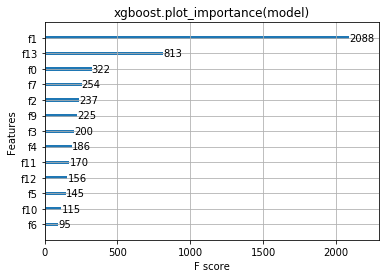

In [139]:
xgboost.plot_importance(xgb)
pl.title("xgboost.plot_importance(model)")
pl.show()

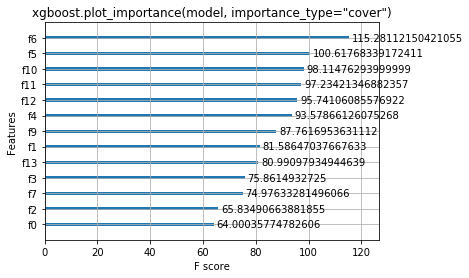

In [141]:
xgboost.plot_importance(xgb, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

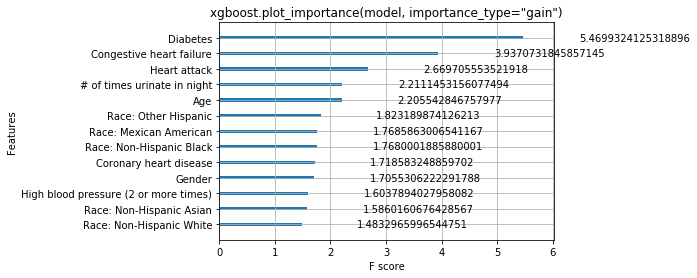

In [86]:
xgboost.plot_importance(model, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

### Explain predictions

In [87]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

### Visualize a single prediction

In [110]:
X_variable = df[df.columns[0:-1]]
type(X_variable)

pandas.core.frame.DataFrame

In [114]:
shap.force_plot(explainer.expected_value, shap_values[0,:],X_variable.iloc[0,:])

In [115]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_variable.iloc[:1000,:])

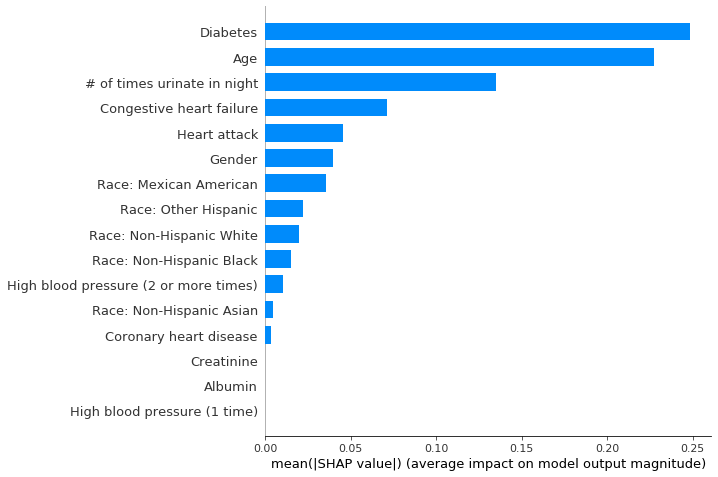

In [116]:
shap.summary_plot(shap_values, X_variable, plot_type="bar")

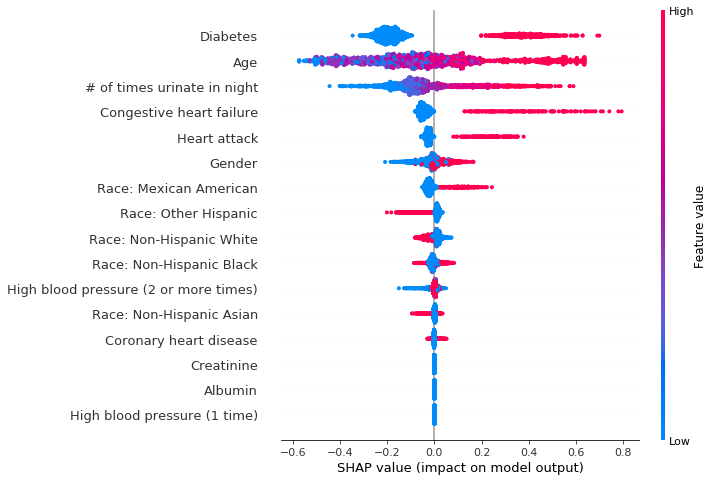

In [117]:
shap.summary_plot(shap_values, X)

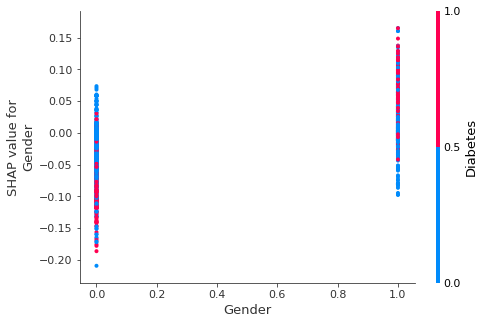

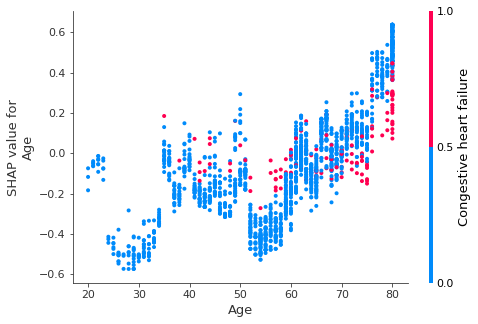

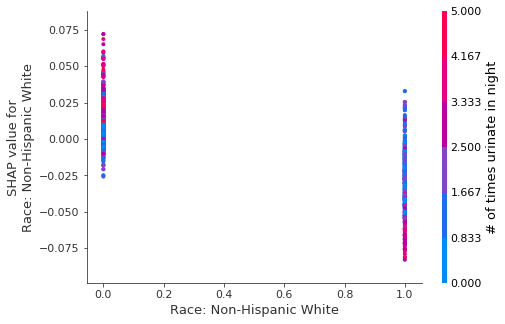

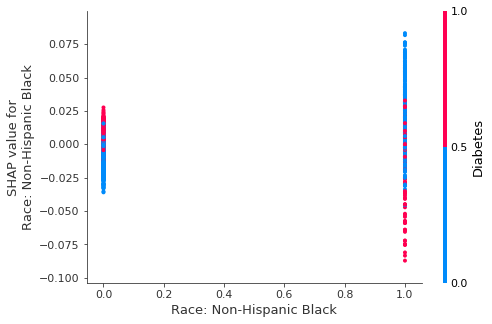

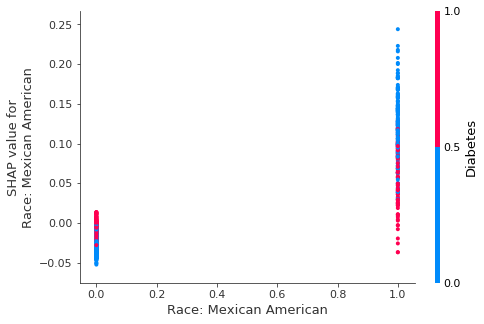

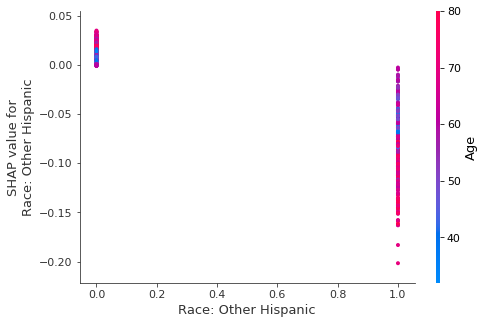

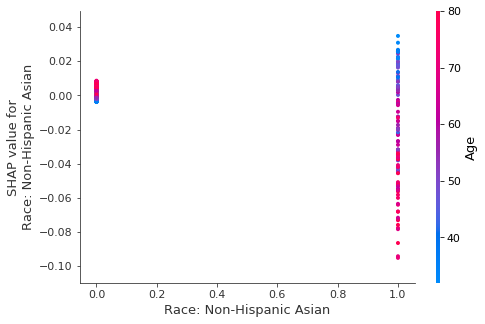

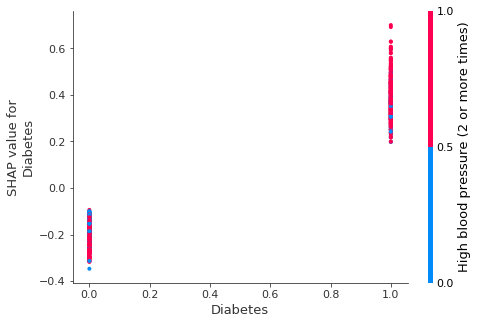

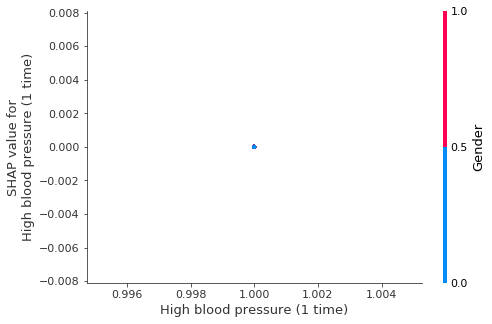

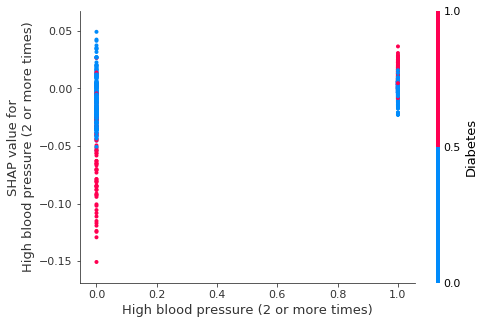

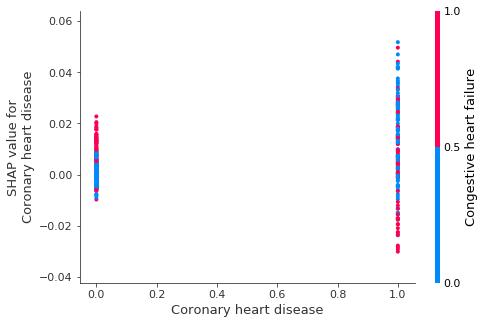

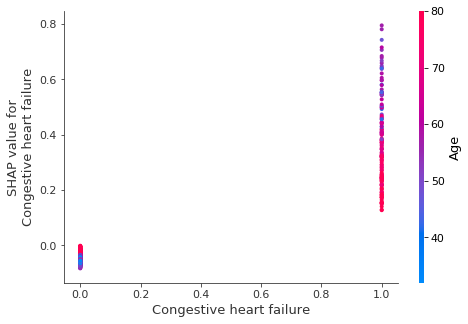

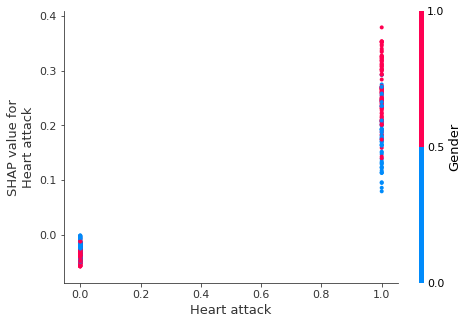

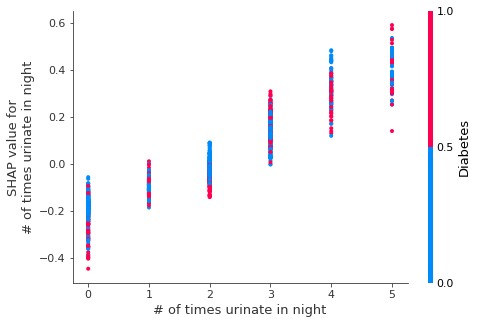

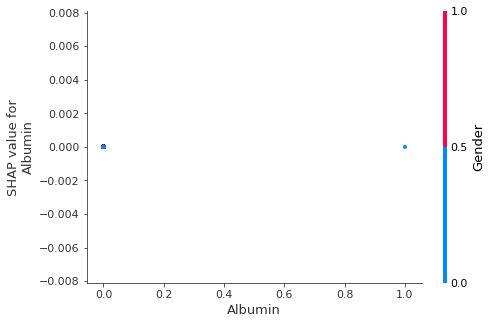

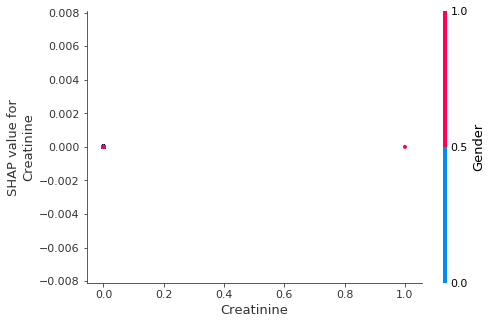

In [120]:
for name in X_variable.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_variable)